In [1]:
import sys
!{sys.executable} -m pip install -U deepposekit

Requirement already up-to-date: deepposekit in c:\users\pranavm\anaconda3\lib\site-packages (0.3.4)


In [7]:
import cv2
import h5py
import matplotlib.pyplot as plt
from deepposekit.io import VideoReader, DataGenerator, initialize_dataset
from deepposekit.annotate import KMeansSampler
import tqdm
import glob
import pandas as pd
import numpy as np

from os.path import expanduser

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

HOME = expanduser("~") if not IN_COLAB else '.'
HOME = HOME +'/Documents/RamanLab'

In [3]:
videos = sorted(glob.glob(HOME + '/Data/*.mp4'))
videos

['C:\\Users\\PranavM/Documents/RamanLab/Data\\1.mp4',
 'C:\\Users\\PranavM/Documents/RamanLab/Data\\WIN_20191009_11_00_36_Pro.mp4',
 'C:\\Users\\PranavM/Documents/RamanLab/Data\\WIN_20191015_12_07_05_Pro.mp4',
 'C:\\Users\\PranavM/Documents/RamanLab/Data\\crop.mp4',
 'C:\\Users\\PranavM/Documents/RamanLab/Data\\cut.mp4',
 'C:\\Users\\PranavM/Documents/RamanLab/Data\\full.mp4',
 'C:\\Users\\PranavM/Documents/RamanLab/Data\\posture.mp4']

In [4]:
reader = VideoReader(HOME + '/Data/crop.mp4', gray=True)
frame = reader[0] # read a frame
reader.close()
frame.shape

(1, 512, 512, 1)

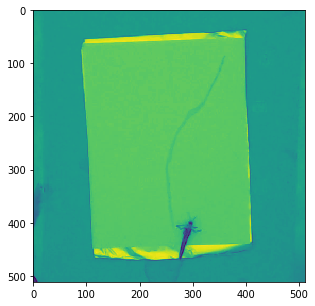

In [5]:
plt.figure(figsize=(5,5))
plt.imshow(frame[0,...,0])
plt.show()

In [8]:
reader = VideoReader(HOME + '/Data/crop.mp4', batch_size=100, gray=True)

randomly_sampled_frames = []
for idx in tqdm.tqdm(range(len(reader)-1)):
    batch = reader[idx]
    random_sample = batch[np.random.choice(batch.shape[0], 10, replace=False)]
    randomly_sampled_frames.append(random_sample)
reader.close()

randomly_sampled_frames = np.concatenate(randomly_sampled_frames)
randomly_sampled_frames.shape

100%|████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  6.83it/s]


(170, 512, 512, 1)

In [9]:
kmeans = KMeansSampler(n_clusters=10, max_iter=1000, n_init=10, batch_size=100, verbose=True)
kmeans.fit(randomly_sampled_frames)

Init 1/10 with method: k-means++
Inertia for init 1/10: 257680485.149135
Init 2/10 with method: k-means++
Inertia for init 2/10: 237134211.010659
Init 3/10 with method: k-means++
Inertia for init 3/10: 258085559.071503
Init 4/10 with method: k-means++
Inertia for init 4/10: 252404022.405743
Init 5/10 with method: k-means++
Inertia for init 5/10: 262098367.544613
Init 6/10 with method: k-means++
Inertia for init 6/10: 258831108.118922
Init 7/10 with method: k-means++
Inertia for init 7/10: 272390131.296737
Init 8/10 with method: k-means++
Inertia for init 8/10: 274722062.379104
Init 9/10 with method: k-means++
Inertia for init 9/10: 265144476.369649
Init 10/10 with method: k-means++
Inertia for init 10/10: 270474381.084203
Minibatch iteration 1/2000: mean batch inertia: 1884992.746716, ewa inertia: 1884992.746716 
Minibatch iteration 2/2000: mean batch inertia: 1776737.569964, ewa inertia: 1776737.569964 
Minibatch iteration 3/2000: mean batch inertia: 1549295.861262, ewa inertia: 15492

KMeansSampler(batch_size=100, compute_labels=True, init='k-means++',
              init_size=None, max_iter=1000, max_no_improvement=10,
              n_clusters=10, n_init=10, random_state=None,
              reassignment_ratio=0.01, tol=0.0, verbose=True)

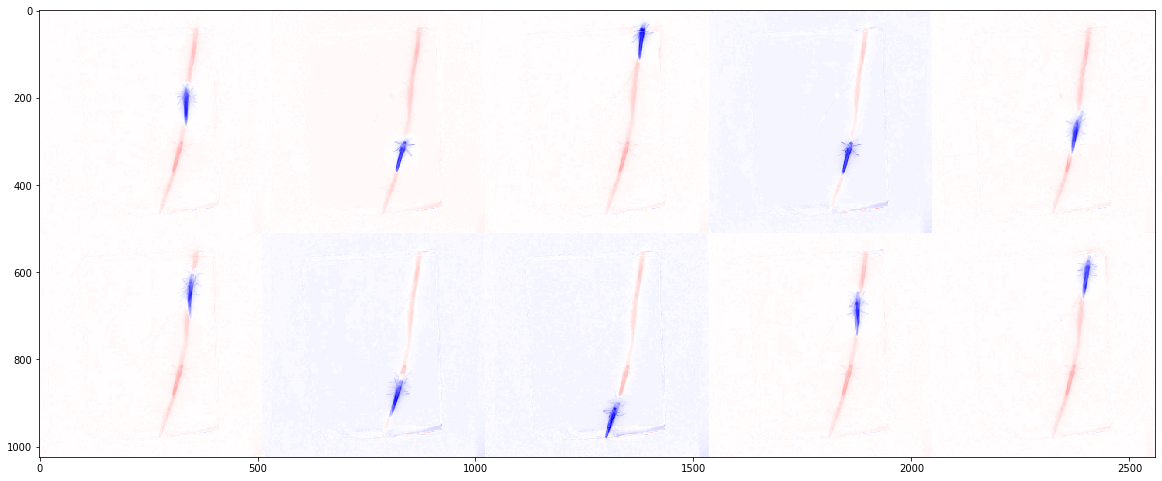

In [10]:
kmeans.plot_centers(n_rows=2)
plt.show()

In [11]:
kmeans_sampled_frames, kmeans_cluster_labels = kmeans.sample_data(randomly_sampled_frames, n_samples_per_label=10)
kmeans_sampled_frames.shape

Computing label assignment and total inertia
Computing label assignment and total inertia


(85, 512, 512, 1)

In [13]:
skeleton = pd.read_csv(HOME + '/deepposekit-data/datasets/locust/skeleton_min.csv')
skeleton

,name,parent,swap
0,head,NaN,NaN
1,neck,head,NaN
2,thorax,neck,NaN
3,abdomen1,thorax,NaN
4,abdomen2,abdomen1,NaN
5,anttipL,NaN,anttipR
6,antbaseL,anttipL,antbaseR
7,eyeL,antbaseL,eyeR
8,forelegL1,NaN,forelegR1
9,forelegL2,forelegL1,forelegR2


In [14]:
initialize_dataset(
    images=kmeans_sampled_frames,
    datapath=HOME + '/deepposekit-data/datasets/locust/example_annotation_set.h5',
    skeleton=HOME + '/deepposekit-data/datasets/locust/skeleton_min.csv',
    # overwrite=True # This overwrites the existing datapath
)

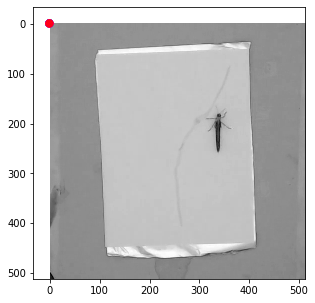

In [18]:
data_generator = DataGenerator(HOME + '/deepposekit-data/datasets/locust/example_annotation_set.h5', mode="full")

image, keypoints = data_generator[0]

plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1:
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, :, 0], keypoints[0, :, 1], c=np.arange(data_generator.keypoints_shape[0]), s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()